In [16]:
import pandas as pd
import numpy as np
import psycopg2
from datetime import datetime, timedelta
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm, kstest, truncnorm
from collections import Counter

In [17]:
days = 1095 # to adjust for backup data loss or else 90
past_date = datetime.now() - timedelta(days=days)
pdate = past_date.strftime('%Y-%m-%d')
pdatetime = datetime.strptime(pdate, '%Y-%m-%d').strftime('%Y-%m-%d %H:%M:%S')
business = 100005

db_config = {'user': 'XXXXXX','password': 'XXXXXX','host': 'XXXXXX','port': '5432', 'database': 'XXXXXX'}
engine = create_engine(f"postgresql+psycopg2://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")

In [18]:
query_caitem = f"""
        SELECT caitem.xitem, caitem.xdesc
        FROM caitem
        WHERE caitem.zid = %(business)s
    """
params_caitem = {'business': business}

query_imtrn = f"""
        SELECT imtrn.xitem,imtrn.xyear, imtrn.xper, imtrn.xdate,imtrn.xqty, imtrn.xval, imtrn.xdocnum
        FROM imtrn 
        WHERE imtrn.zid = %(business)s
        AND imtrn.xdate >= %(date)s
        AND imtrn.xdocnum LIKE %(docnum)s
    """
params_imtrn = {'business': business, 'date': pdate, 'docnum':'DO--%'}
caitem_data = pd.read_sql(query_caitem, con=engine, params=params_caitem)
imtrn_data = pd.read_sql(query_imtrn, con=engine, params=params_imtrn)

query_opddt = f"""
        SELECT opddt.ztime, opddt.xitem, opddt.xordernum, opddt.xdornum
        FROM opddt
        WHERE opddt.zid = %(business)s
        AND opddt.ztime >= %(datetime)s
    """
params_opddt = {'business': business, 'datetime': pdatetime}

query_opodt = f"""
        SELECT opodt.xitem, opodt.xlineamt, opodt.xordernum, opord.xdate
        FROM opodt
        JOIN opord
        ON opodt.xordernum = opord.xordernum
        WHERE opodt.zid = %(business)s
        AND opord.zid = %(business)s
        AND opord.xdate >= %(date)s
    """
params_opodt = {'business': business, 'date': pdate}

opddt_data = pd.read_sql(query_opddt, con=engine, params=params_opddt)
opodt_data = pd.read_sql(query_opodt, con=engine, params=params_opodt)

imtrn_data = imtrn_data.groupby(['xitem', 'xdocnum']).agg({
    'xqty': 'sum',      
    'xval': 'sum',       
    'xyear': 'first',    
    'xdate': 'first',    
    'xper': 'first'      
}).reset_index()

opodt_data_aggregated = opodt_data.groupby(['xitem', 'xordernum']).agg({
    'xlineamt': 'sum',
    'xdate': 'first'
}).reset_index()

opddt_data = opddt_data.drop(columns=['ztime'])
opddt_data = opddt_data.drop_duplicates(subset=['xitem', 'xordernum', 'xdornum'])

# merge all the data and aggregate duplicates (discounts and bundle offers)
merged_1 = pd.merge(imtrn_data, opddt_data, left_on=['xitem','xdocnum'], right_on=['xitem','xdornum'], how='left')
merged_2 = pd.merge(merged_1, opodt_data, left_on=['xitem','xordernum'], right_on=['xitem','xordernum'], how='left')

merged_2 = merged_2.groupby(['xitem', 'xdocnum','xordernum','xdornum']).agg({
    'xqty': 'sum',      
    'xval': 'sum',       
    'xyear': 'first',
    'xdate_x': 'first',
    'xper': 'first',
    'xlineamt': 'sum',    
    'xdate_y': 'first'      
}).reset_index()

final_merged = pd.merge(merged_2, caitem_data, left_on='xitem', right_on='xitem', how='left')
sales_data = final_merged[['xitem', 'xdesc', 'xdocnum','xyear','xper', 'xqty', 'xval', 'xlineamt']]

In [19]:
month_sales_df = sales_data.groupby(['xitem', 'xdesc', 'xyear', 'xper']).agg({
        'xqty': 'sum',
        'xval': 'sum',
        'xlineamt': 'sum'}).reset_index()

In [20]:
month_sales_df['Profit'] = month_sales_df['xlineamt'] - month_sales_df['xval']
month_sales_df['Profit/unit'] = month_sales_df['Profit']/month_sales_df['xqty']
month_sales_df = month_sales_df[month_sales_df['Profit'] > 0]
month_sales_df = month_sales_df[month_sales_df['xyear'] > 2020]

In [21]:
#create a distribution type table for all the products within the monthly sales data. using ks-test and p values
#need to investigate the shape, location and scale of lognormal and see why the random generations are relegated to the upper threshold
# Done separately to verify distribution type
grouped = month_sales_df.groupby('xitem')
distribution_summary = []

for product_code, product_data in grouped:
    
    #Demand or quantity sold distribution for all the months for this product within the sales data
    demand_mean, demand_std = norm.fit(product_data['xqty'])
    ks_stat_normal, p_value_normal = kstest(product_data['xqty'], 'norm', args=(demand_mean, demand_std))

    log_shape, log_loc, log_scale = lognorm.fit(product_data['xqty'], floc=0)
    ks_stat_lognorm, p_value_lognorm = kstest(product_data['xqty'], 'lognorm', args=(log_shape, log_loc, log_scale))

    if p_value_normal > 0.05:
        best_fit_demand = 'Normal'
    elif p_value_lognorm > 0.05:
        best_fit_demand = 'Lognormal'
    else:
        best_fit_demand = 'Empirical'

    profitr_mean, profitr_std = norm.fit(product_data['Profit/unit'])
    ks_stat_normal_profitr, p_value_normal_profitr = kstest(product_data['Profit/unit'], 'norm', args=(profitr_mean, profitr_std))

    log_shape_profitr, log_loc_profitr, log_scale_profitr = lognorm.fit(product_data['Profit/unit'], floc=0)
    ks_stat_lognorm_profitr, p_value_lognorm_profitr = kstest(product_data['Profit/unit'], 'lognorm', args=(log_shape_profitr, log_loc_profitr, log_scale_profitr))

    if p_value_normal_profitr > 0.05:
        best_fit_profit = 'Normal'
    elif p_value_lognorm_profitr > 0.05:
        best_fit_profit = 'Lognormal'
    else:
        best_fit_profit = 'Empirical'

    distribution_summary.append({
        'xitem': product_code,
        'Demand_Distribution': best_fit_demand,
        'Profit_Ratio_Distribution': best_fit_profit
    })

distribution_summary_df = pd.DataFrame(distribution_summary)

/Users/anilsaddatbijoy/.pyenv/versions/3.6.9/envs/hmbrWork/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1844: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [22]:
#Take the distribution type from the previously created dataframe and 
#create scenarios with given probabilities based on the distribution type
num_scenarios = 3
num_bins = 10
scenarios_list = []

for index, row in distribution_summary_df.iterrows():
    product_code = row['xitem']
    demand_dist = row['Demand_Distribution']
    profit_dist = row['Profit_Ratio_Distribution']
    product_data = month_sales_df[month_sales_df['xitem'] == product_code]
    
    #For demand scenarios
    if demand_dist == 'Normal':
        demand_mean, demand_std = norm.fit(product_data['xqty'])
        lower, upper = 0, product_data['xqty'].max()
        a, b = (lower - demand_mean)/ demand_std, (upper - demand_mean) / demand_std
        demand_scenarios = truncnorm.rvs(a, b, loc=demand_mean, scale=demand_std, size=num_scenarios)
        demand_probabilities = norm.pdf(demand_scenarios, demand_mean, demand_std)
        demand_probabilities /= demand_probabilities.sum()
    else: #lognormal and empirical
        demand_bins = pd.cut(product_data['xqty'],bins=num_bins)
        bin_counts = demand_bins.value_counts()
        bin_probabilities = bin_counts / bin_counts.sum()
        bin_intervals = bin_probabilities.index
        
        demand_scenarios = []
        demand_probabilities = []
        for _ in range(num_scenarios):
            chosen_bin = np.random.choice(bin_intervals, p=bin_probabilities)
            demand_scenarios.append(np.random.uniform(chosen_bin.left, chosen_bin.right))
            demand_probabilities.append(bin_probabilities[chosen_bin])
        
        demand_probabilities = np.array(demand_probabilities)
        demand_probabilities /= demand_probabilities.sum()
        
    # For profit ratio scenarios
    if profit_dist == 'Normal':
        profit_mean, profit_std = norm.fit(product_data['Profit/unit'])
        lower, upper = 0, product_data['Profit/unit'].max()
        a, b = (lower - profit_mean)/ profit_std, (upper - profit_mean) / profit_std
        profitr_scenarios = truncnorm.rvs(a, b, loc=profit_mean, scale=profit_std, size=num_scenarios)
        profit_probabilities = norm.pdf(profitr_scenarios, profit_mean, profit_std)
        profit_probabilities /= profit_probabilities.sum()
    else: #lognormal and empirical
        profit_bins = pd.cut(product_data['Profit/unit'],bins=num_bins)
        bin_counts = profit_bins.value_counts()
        bin_probabilities = bin_counts / bin_counts.sum()
        bin_intervals = bin_probabilities.index
        
        profitr_scenarios = []
        profitr_probabilities = []
        for _ in range(num_scenarios):
            chosen_bin = np.random.choice(bin_intervals, p=bin_probabilities)
            profitr_scenarios.append(np.random.uniform(chosen_bin.left, chosen_bin.right))
            profitr_probabilities.append(bin_probabilities[chosen_bin])
        
        profitr_probabilities = np.array(profitr_probabilities)
        profitr_probabilities /= profitr_probabilities.sum()

    profit_scenarios = [demand * ratio for demand, ratio in zip(demand_scenarios, profitr_scenarios)]
    scenario_probabilities = (np.array(demand_probabilities) + np.array(profit_probabilities)) / 2

    product_scenarios = pd.DataFrame({
        'Scenario': range(1, num_scenarios + 1),
        'Probability': scenario_probabilities,
        'Product_Code': [product_code] * num_scenarios,
        'Demand/month': demand_scenarios,
        'Total_Profit': profit_scenarios
    })
    
    scenarios_list.append(product_scenarios)
scenarios_df = pd.concat(scenarios_list, ignore_index=True)


In [23]:
scenarios_df.to_excel('scenarios.xlsx')

In [24]:
month_sales_df.to_excel('month_sales.xlsx')

In [25]:
distribution_summary_df.to_excel('dist_summary.xlsx')

In [42]:
pd.set_option('display.max_rows', None)

In [46]:
month_sales_df

,xitem,xdesc,xyear,xper,xqty,xval,xlineamt,Profit,Profit/unit
19,FZ000003,Floor Cleaner New,2021,10,75.000,5164.820742,9960.00,4795.179258,63.935723
20,FZ000003,Floor Cleaner New,2021,11,102.000,6319.363164,16766.00,10446.636836,102.418008
21,FZ000003,Floor Cleaner New,2021,12,93.000,5476.016609,11786.00,6309.983391,67.849284
22,FZ000003,Floor Cleaner New,2022,1,80.000,4661.000276,10956.00,6294.999724,78.687497
23,FZ000003,Floor Cleaner New,2022,2,97.000,5664.504636,11454.00,5789.495364,59.685519
24,FZ000003,Floor Cleaner New,2022,3,65.000,4017.107071,8964.00,4946.892929,76.106045
25,FZ000003,Floor Cleaner New,2022,4,46.000,2960.971443,7636.00,4675.028557,101.631056
26,FZ000003,Floor Cleaner New,2022,5,103.000,7128.175237,10126.00,2997.824763,29.105095
27,FZ000003,Floor Cleaner New,2022,6,124.000,8563.839807,16034.00,7470.160193,60.243227
28,FZ000003,Floor Cleaner New,2022,7,86.000,6153.363870,14388.00,8234.636130,95.751583


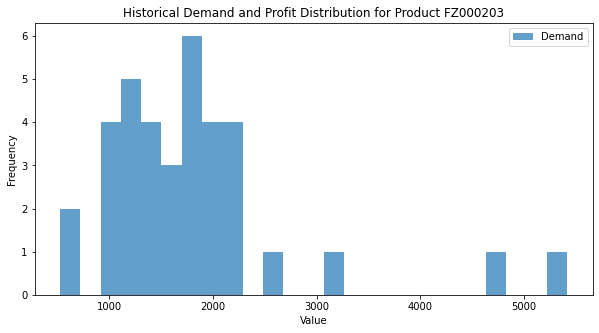

In [52]:
#check individual product distributions
p028 = month_sales_df[month_sales_df['xitem']=='FZ000028']
plt.figure(figsize=(10, 5))
plt.hist(p028['xqty'], bins=25, alpha=0.7, label='Demand')
# plt.hist(month_sales_df['Profit'], bins=20, alpha=0.7, label='Profit')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Historical Demand and Profit Distribution for Product {product_code}')
plt.show()

In [36]:
demand_mean, demand_std = norm.fit(p005['xqty'])
print(f'Estimated parameters for demand - Mean: {demand_mean}, Std Dev: {demand_std}')

profit_mean, profit_std = norm.fit(p005['Profit'])
print(f'Estimated parameters for profit - Mean: {profit_mean}, Std Dev: {profit_std}')

Estimated parameters for demand - Mean: 1970.2222222222222, Std Dev: 950.8084604141161
Estimated parameters for profit - Mean: 58027.47845161111, Std Dev: 24447.76679564005


In [37]:
from scipy.stats import kstest

# Test goodness of fit for demand
ks_stat, p_value = kstest(p005['xqty'], 'norm', args=(demand_mean, demand_std))
print(f'K-S test statistic for demand: {ks_stat}, p-value: {p_value}')

# Interpret the p-value (p > 0.05 means the distribution fits well)
if p_value > 0.05:
    print("The normal distribution is a good fit for demand.")
else:
    print("The normal distribution may not be a good fit for demand.")

K-S test statistic for demand: 0.1255904213201191, p-value: 0.5778438294190176
The normal distribution is a good fit for demand.


In [ ]:
#stochastic for zepto using more scenarios